# Data preparation

## Support functions

In [1]:
import numpy as np
from PIL import Image                

image_size = 224
random_img = Image.fromarray(np.random.rand(image_size, image_size) * 255)
random_img = random_img.convert('RGB')

def path_to_image(img_path):
    final_img = random_img.copy()  # random content image (to ensure the proper size)
    img = Image.open(img_path)
    img.thumbnail((image_size, image_size), Image.LANCZOS)  # rescaled image (preserves aspect ratio)
    offset = (int((image_size - img.width)/2), int((image_size - img.height)/2))
    final_img.paste(img, offset)
    return final_img

## Data preprocessing

In [2]:
#
# Resizing and centering images
#
# Note: the original 16 validation images go into the training folder
#       a bigger validation dataset is created out of the training folder
#

import shutil, os, random
from glob import glob

valid_perc = 20
test_perc = 20

data_orig = 'dataset'
if data_orig[-1] != '/':
    data_orig += '/'
data_sets = [name[8:-1] for name in glob(data_orig + '*/')]
data_dest = data_orig + 'resized/'

category_names = [name[14:-1] for name in glob(data_orig + 'train/*/')]

try:
    # creating folder hierarchy
    os.mkdir(data_dest)
    for dataset in data_sets:
        os.mkdir(data_dest + dataset)
        for category in category_names:
            os.mkdir(data_dest + dataset + '/' + category)
    print('\rCreated folder hierarchy...')

    # resizing the images and placing them in the proper folders
    for dataset in data_sets:
        for category in category_names:
            for infile in glob(data_orig + dataset + '/' + category + '/*.jpeg'):
                print('\rProcessing ' + infile + (30 * ' '), end='')
                outfile = infile.replace(data_orig, data_dest).replace('val', 'train').replace('test', 'train')
                path_to_image(infile).save(outfile)
    print('\rCreated folder hierarchy and copied preprocessed images...')

    for category in category_names:
        train_files = glob(data_dest + '/train/' + category + '/*')
        num_files = len(train_files)
        # validation files from training folder
        num_valid_files = int(round(num_files * valid_perc / 100))
        valid_files = random.sample(train_files, num_valid_files)
        for filename in valid_files:
            shutil.move(filename, filename.replace('train', 'val'))
        # test files from training folder
        train_files = glob(data_dest + 'train/' + category + '/*')
        num_test_files = int(round(num_files * test_perc / 100))
        test_files = random.sample(train_files, num_test_files)
        for filename in test_files:
            shutil.move(filename, filename.replace('train', 'test'))
    print('Rearranged train, validation and test datasets into {}:{}:{} ratio...'.format(
        int(100 - valid_perc - test_perc), int(valid_perc), int(test_perc)))
except FileExistsError:
    print('Rearranged dataset already exists - nothing to do.')

Rearranged dataset already exists - nothing to do.


## Data inspection

In [3]:
#
# Data Inspection
#

import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline

# display some sample images
for i in range(0):
    # original image
    print(train_files[i])
    plt.imshow(cv2.cvtColor(cv2.imread(train_files[i]), cv2.COLOR_BGR2RGB))
    plt.show()
    # show final image
    plt.imshow(cv2.cvtColor(np.asarray(path_to_image(train_files[i])), cv2.COLOR_BGR2RGB))
    plt.show()

# Transfer learning

In [4]:
from tensorflow.python.keras.applications import mobilenet
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D

# Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()

model.add(mobilenet_model)
for layer in model.layers:
    layer.trainable=False

# custom layers on top
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
# dense for 2-class classification using softmax activation
model.add(Dense(len(category_names), activation='softmax'))

#from tensorflow.python.keras import optimizers
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss=('categorical_crossentropy'), metrics=['accuracy'])
model.compile(optimizer='adam', loss=('categorical_crossentropy'), metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total para

In [5]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = int(0.5*(100 - valid_perc))
BATCH_SIZE_VALIDATION = int(0.5 * valid_perc)

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        'dataset/resized/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        'dataset/resized/val',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

test_generator = data_generator.flow_from_directory(
        'dataset/resized/test',
        target_size=(image_size, image_size),
        batch_size=50,  # 100 causes ResourceExhaustedError
        class_mode='categorical',
        shuffle=False)

# Calculating weights to compensate class unbalance in training dataset
from sklearn.utils.class_weight import compute_class_weight
cat_train = train_generator.classes
class_weights_list = compute_class_weight('balanced', np.unique(cat_train), cat_train)
class_weights = {i: class_weights_list[i] for i in range(0, len(class_weights_list))}
print('Class weights:', class_weights)

Found 3512 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


Using TensorFlow backend.


Found 1172 images belonging to 2 classes.
Class weights: {0: 1.850368809272919, 1: 0.685134607881389}


In [6]:
# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 20  # probably 15 is maximum useful...
EARLY_STOP_PATIENCE = 5

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = int(100 - valid_perc - test_perc)
STEPS_PER_EPOCH_VALIDATION = int(valid_perc)

# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

weights_filename = 'saved_models/best.mobilenet.h5'

cb_early_stopper = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath=weights_filename, verbose=True,
                                  monitor='val_loss', save_best_only=True, mode='auto')

fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper],
        class_weight=class_weights
)

Epoch 1/20
59/60 [============================>.] - ETA: 0s - loss: 0.4060 - acc: 0.8360
Epoch 00001: val_loss improved from inf to 0.32040, saving model to saved_models/best.mobilenet.h5
60/60 [==============================] - 44s 732ms/step - loss: 0.4030 - acc: 0.8379 - val_loss: 0.3204 - val_acc: 0.8050
Epoch 2/20
59/60 [============================>.] - ETA: 0s - loss: 0.2341 - acc: 0.9104
Epoch 00002: val_loss improved from 0.32040 to 0.21480, saving model to saved_models/best.mobilenet.h5
60/60 [==============================] - 38s 641ms/step - loss: 0.2341 - acc: 0.9102 - val_loss: 0.2148 - val_acc: 0.9250
Epoch 3/20
59/60 [============================>.] - ETA: 0s - loss: 0.1943 - acc: 0.9232
Epoch 00003: val_loss improved from 0.21480 to 0.14143, saving model to saved_models/best.mobilenet.h5
60/60 [==============================] - 37s 623ms/step - loss: 0.1948 - acc: 0.9232 - val_loss: 0.1414 - val_acc: 0.9600
Epoch 4/20
59/60 [============================>.] - ETA: 0s - 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


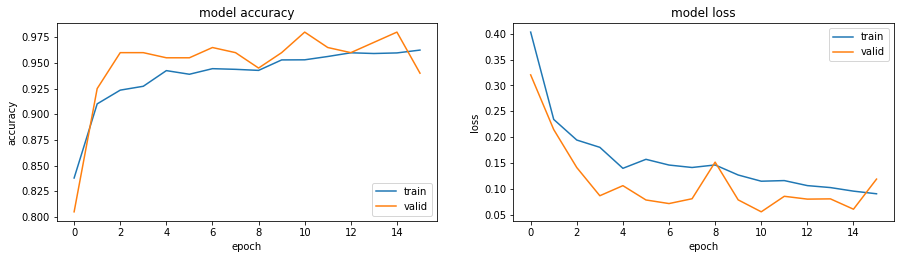

In [7]:
print(fit_history.history.keys())

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [8]:
model.load_weights(weights_filename)
predictions = model.predict_generator(test_generator)

In [9]:
cat_test = test_generator.classes
y_pred = [cat_prob[1] for cat_prob in predictions]
cat_pred = [np.argmax(cat_prob) for cat_prob in predictions]
cat_pred = np.argmax(predictions, axis=1)
print('Debug:', y_pred[:5], len(y_pred))
print('Debug:', cat_pred[:10], cat_pred[-10:], len(cat_pred))
print('Debug:', cat_test[:10], cat_test[-10:], len(cat_test))

Debug: [0.0006121502, 0.009202177, 0.801813, 0.004642924, 0.004365094] 1172
Debug: [0 0 1 0 0 0 0 0 0 0] [1 1 1 1 1 1 1 1 1 1] 1172
Debug: [0 0 0 0 0 0 0 0 0 0] [1 1 1 1 1 1 1 1 1 1] 1172


In [10]:
# report test accuracy
test_accuracy = 100 * np.sum(cat_pred==cat_test) / len(cat_pred)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 96.0751%


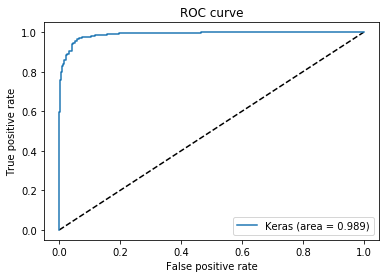

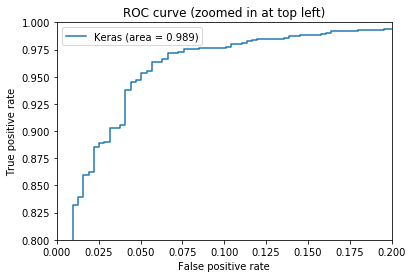

In [11]:
#
# ROC curve
#

from sklearn.metrics import roc_curve, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(cat_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [12]:
#
# Confusion Matrix
#

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(cat_test, cat_pred)
print(cm / np.sum(cm))

[[0.25255973 0.01791809]
 [0.02133106 0.70819113]]
